SAIDL 2024 Spring Assignment

Author: Shanay Mehta

**Packages**

In [1]:
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import MNIST
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

In [2]:
torch.random.manual_seed(1)
np.random.seed(1)

**Loading the MNIST Dataset:**

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = './datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Display images**

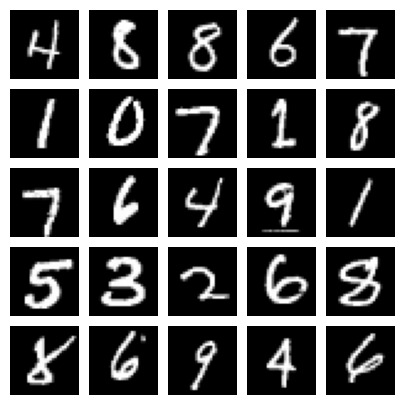

In [4]:
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

**VAE base model**

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim1=256, hidden_dim2=128, latent_dim=16, device=device):
        super(VAE, self).__init__()
        self.ld = latent_dim
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim2, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, std_dev):
        epsilon = torch.randn_like(std_dev).to(device)
        z = mean + std_dev*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

    def generate(self, inp_mean, inp_std_dev, num_samples = 1):
        z = torch.normal(inp_mean, inp_std_dev, size=(num_samples, self.ld)).to(device)
        x_hat = self.decode(z)
        x_hat = x_hat.detach().cpu().reshape(num_samples, 28, 28)
        return x_hat


In [6]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

**Loss for the VAE base model**

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [8]:
from google.colab import drive

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Training the model**

In [10]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        with tqdm(train_loader, desc='train') as progress_bar:
          for batch_idx, (x, _) in enumerate(progress_bar):
              x = x.view(batch_size, x_dim).to(device)

              optimizer.zero_grad()

              x_hat, mean, log_var = model.forward(x)
              loss = loss_function(x, x_hat, mean, log_var)

              overall_loss += loss.item()

              loss.backward()
              optimizer.step()

        print("\tEpoch", epoch + 1, "lr", optimizer.param_groups[0]['lr'], "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))

        # Save the model checkpoint after each epoch
        path = '/content/drive/MyDrive/SAiDL_CV/vae_model.pth'
        torch.save(model.state_dict(), path)

    return overall_loss

In [11]:
train(model, optimizer, epochs=20, device=device)

train: 100%|██████████| 600/600 [00:16<00:00, 36.84it/s]


	Epoch 1 lr 0.001 	Average Loss:  174.8938753065004


train: 100%|██████████| 600/600 [00:08<00:00, 73.65it/s]


	Epoch 2 lr 0.001 	Average Loss:  127.863556594976


train: 100%|██████████| 600/600 [00:08<00:00, 68.99it/s]


	Epoch 3 lr 0.001 	Average Loss:  118.84658343332637


train: 100%|██████████| 600/600 [00:08<00:00, 71.61it/s]


	Epoch 4 lr 0.001 	Average Loss:  114.67943618596098


train: 100%|██████████| 600/600 [00:08<00:00, 71.43it/s]


	Epoch 5 lr 0.001 	Average Loss:  112.0551082696421


train: 100%|██████████| 600/600 [00:08<00:00, 68.50it/s]


	Epoch 6 lr 0.001 	Average Loss:  110.35695372821891


train: 100%|██████████| 600/600 [00:08<00:00, 74.10it/s]


	Epoch 7 lr 0.001 	Average Loss:  109.12249832076898


train: 100%|██████████| 600/600 [00:08<00:00, 69.84it/s]


	Epoch 8 lr 0.001 	Average Loss:  108.06384113496452


train: 100%|██████████| 600/600 [00:09<00:00, 65.45it/s]


	Epoch 9 lr 0.001 	Average Loss:  107.27924638394721


train: 100%|██████████| 600/600 [00:09<00:00, 65.66it/s]


	Epoch 10 lr 0.001 	Average Loss:  106.61138440369366


train: 100%|██████████| 600/600 [00:08<00:00, 73.06it/s]


	Epoch 11 lr 0.001 	Average Loss:  106.04016710794032


train: 100%|██████████| 600/600 [00:10<00:00, 59.95it/s]


	Epoch 12 lr 0.001 	Average Loss:  105.52444696238523


train: 100%|██████████| 600/600 [00:07<00:00, 75.65it/s]


	Epoch 13 lr 0.001 	Average Loss:  105.10328845602045


train: 100%|██████████| 600/600 [00:15<00:00, 39.67it/s]


	Epoch 14 lr 0.001 	Average Loss:  104.76011462789545


train: 100%|██████████| 600/600 [00:08<00:00, 74.92it/s]


	Epoch 15 lr 0.001 	Average Loss:  104.376236647668


train: 100%|██████████| 600/600 [00:08<00:00, 68.84it/s]


	Epoch 16 lr 0.001 	Average Loss:  104.08764175644303


train: 100%|██████████| 600/600 [00:08<00:00, 71.55it/s]


	Epoch 17 lr 0.001 	Average Loss:  103.7731292877452


train: 100%|██████████| 600/600 [00:08<00:00, 72.48it/s]


	Epoch 18 lr 0.001 	Average Loss:  103.53432755764817


train: 100%|██████████| 600/600 [00:08<00:00, 68.64it/s]


	Epoch 19 lr 0.001 	Average Loss:  103.30163527754591


train: 100%|██████████| 600/600 [00:08<00:00, 74.85it/s]

	Epoch 20 lr 0.001 	Average Loss:  103.10116261477462


6175759.640625

**Loading the trained model**

In [12]:
# Load the saved model
load_path = '/content/drive/MyDrive/SAiDL_CV/vae_model.pth'
loaded_model = VAE().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAiDL_CV/vae_model.pth


**Generating new images by sampling encodings from N(0,1) and N(1,2) distributions**

In [13]:
num_images_gen = 50
digit_normal = loaded_model.generate(0, 1, num_images_gen)
digit_gaussian = loaded_model.generate(1, 2, num_images_gen)

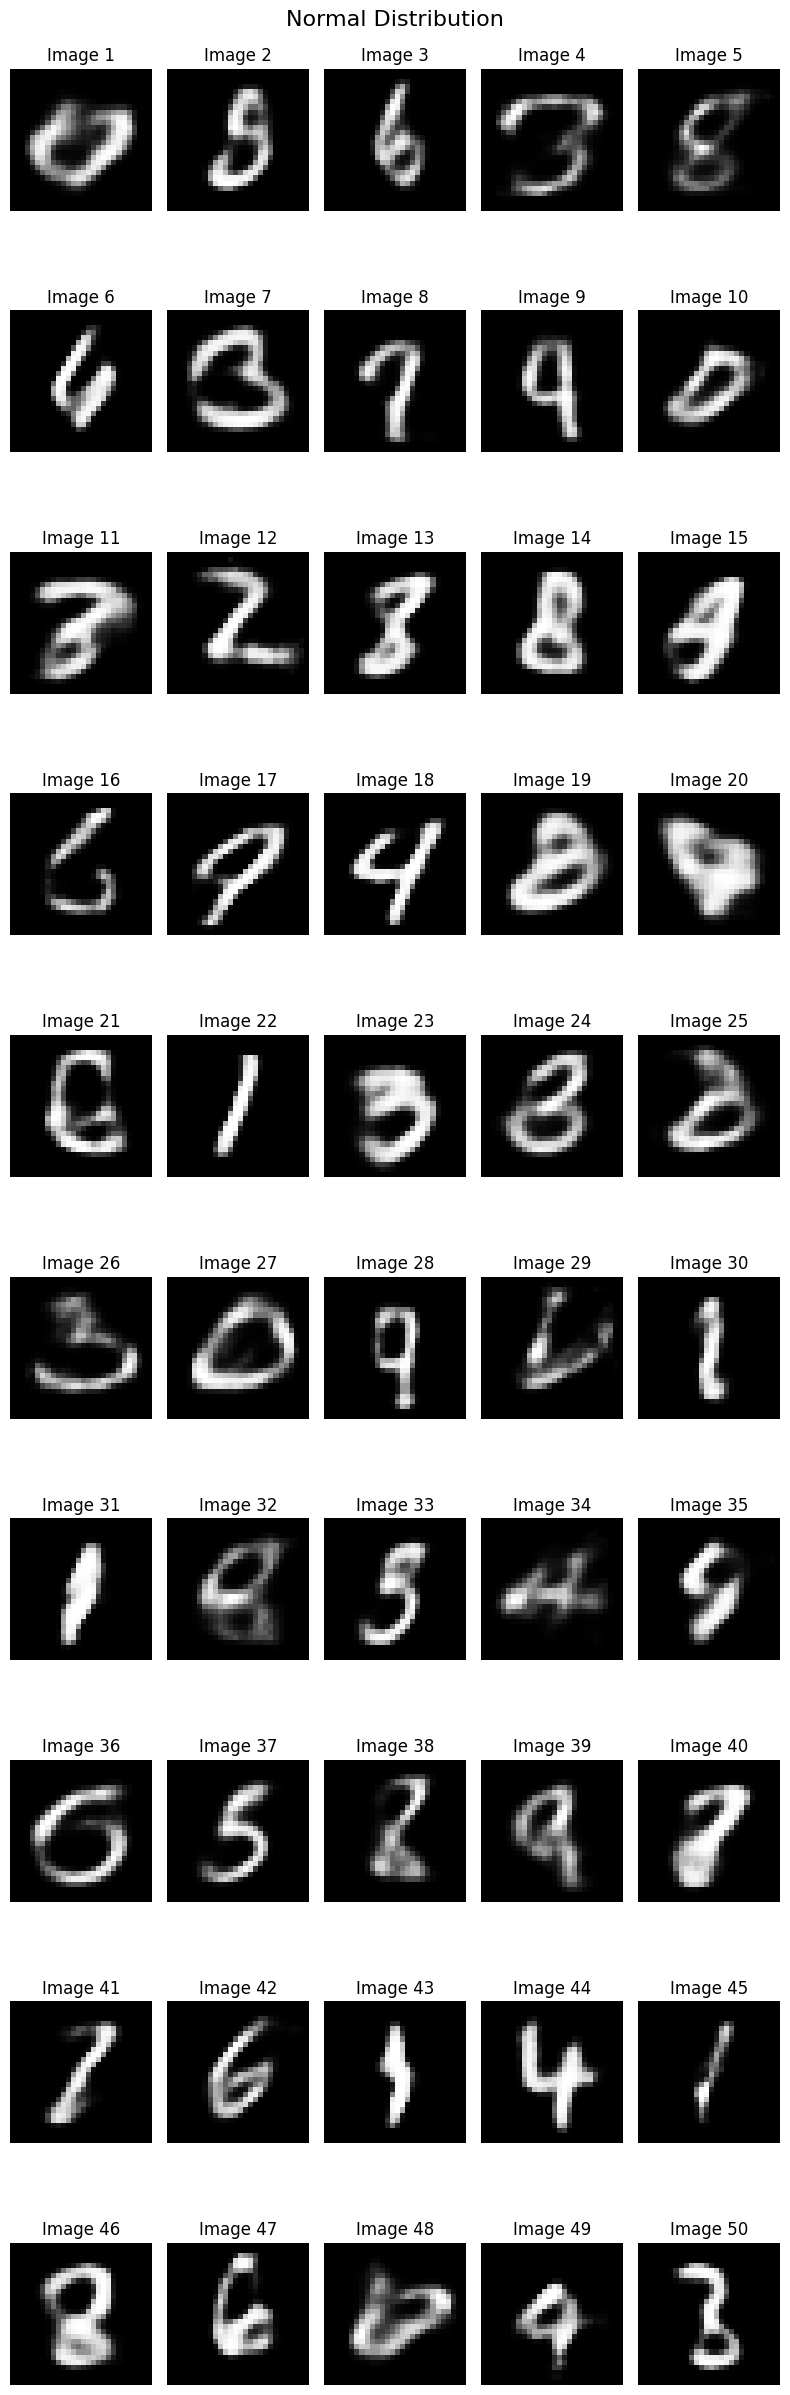

In [14]:
# Plot the generated digits
plt.figure(figsize=(8, 25))  # Adjust the figure size as needed

for i in range(num_images_gen):
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns (50 images in total)
    plt.imshow(digit_normal[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.suptitle('Normal Distribution', fontsize=16)  # Add the heading
plt.tight_layout()
plt.show()

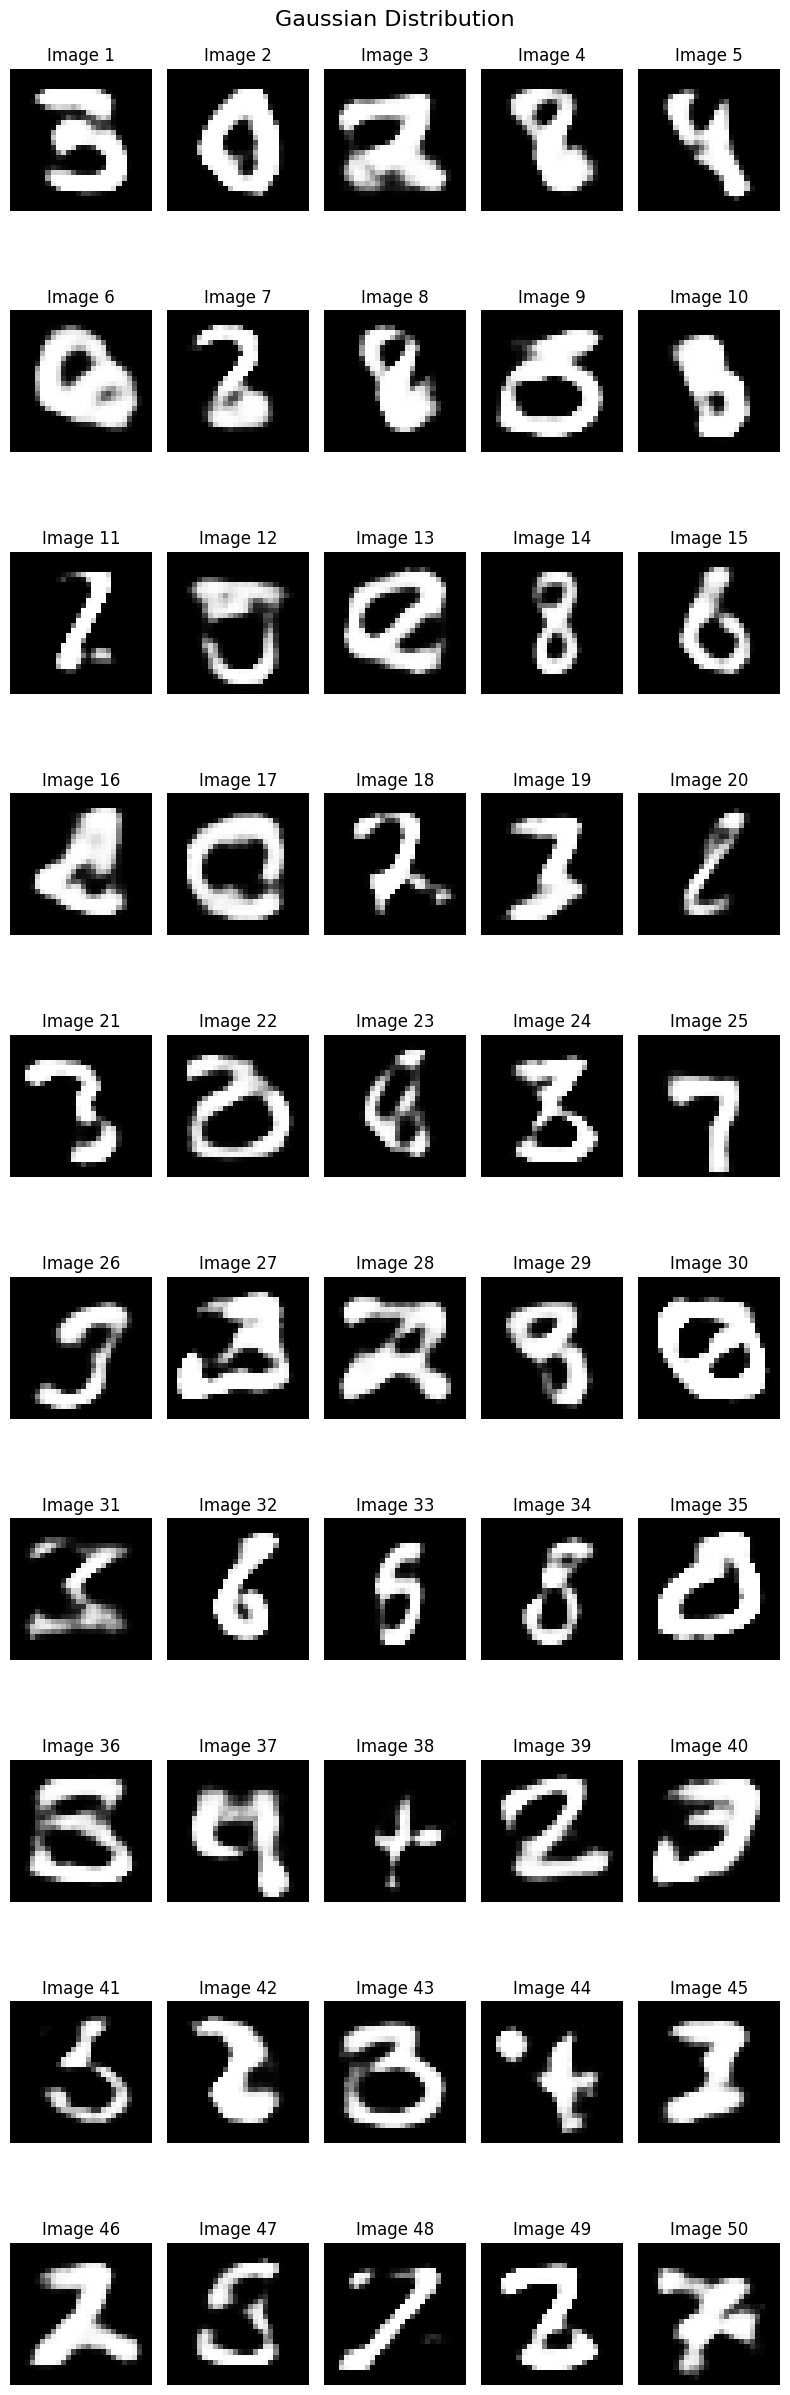

In [15]:
# Plot the generated digits
plt.figure(figsize=(8, 25))  # Adjust the figure size as needed

for i in range(num_images_gen):
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns (50 images in total)
    plt.imshow(digit_gaussian[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.suptitle('Gaussian Distribution', fontsize=16)  # Add the heading
plt.tight_layout()
plt.show()

**Qualitative comparison:**

1. It is clear from the images generated that sampling from N(0,1) gives better images as compared to N(1,2).

2. All the images generated by N(0,1) are clear except some 8's which look distorted.

3. The images generated by N(1,2) are also somewhat clear but the boundaries of the numbers generated are thicker than usual(i.e. the training set). Apart from this, 8's again are very distorted and some of them are even unrecognisable. Some 3's and 2's are also not correctly generated.

4. Based on the above observations, we can conclude that sampling from N(0,1) gives better results. This result is expected because we have used a loss which forces the distribution(used for sampling) to be N(0,1)(KL Divergence term enforces this) and hence trains the decoder accordingly.

**Modifying the VAE model to obtain better images for N(1,2) distribution:**

I have taken the following steps to improve image generation from N(1,2) distribution:

1. **Change the KL Divergence loss:** The reason why N(0,1) gave better results is because the KL Divergence loss forces encoding to a N(0,1) distribution. This trains the decoder only on points sampled from a distribution very close to N(0,1). So, when we give points from N(1,2), we get unexpected results. Due to this, I have changed the KL Divergence loss to push for a mean of value 1 and have reduced the variance term by a factor of 2 to push for a larger variance.

2. **Change the weighting between reconstruction loss and KL Loss:** Even though I have modified the KL Loss term, I am uncertain whether the new expression correctly represents the KL Divergence between N(1,2) and the sampling distribution. So, I have scaled down the impact of KL Loss term.

3. **Added dropout:** Dropout is a widely used method to prevent overfitting of data.

In [16]:
class VAE_mod(nn.Module):

    def __init__(self, input_dim=784, hidden_dim1=256, hidden_dim2=128, latent_dim=16, device=device):
        super(VAE_mod, self).__init__()
        self.ld = latent_dim
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim2, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.Dropout(0.2), # Added dropout to reduce overfitting
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, std_dev):
        epsilon = torch.randn_like(std_dev).to(device)
        z = mean + std_dev*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

    def generate(self, inp_mean, inp_std_dev, num_samples = 1):
        z = torch.normal(inp_mean, inp_std_dev, size=(num_samples, self.ld)).to(device)
        x_hat = self.decode(z)
        x_hat = x_hat.detach().cpu().reshape(num_samples, 28, 28)
        return x_hat


In [17]:
model_mod = VAE_mod().to(device)
optimizer = Adam(model_mod.parameters(), lr=1e-3)

In [18]:
def loss_function_mod(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - (mean-1).pow(2) - (log_var.exp()/2))
    return reproduction_loss + 0.6*KLD

**Training the modified VAE model**

In [19]:
def train_mod(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        with tqdm(train_loader, desc='train') as progress_bar:
          for batch_idx, (x, _) in enumerate(progress_bar):
              x = x.view(batch_size, x_dim).to(device)

              optimizer.zero_grad()

              x_hat, mean, log_var = model.forward(x)
              loss = loss_function_mod(x, x_hat, mean, log_var)

              overall_loss += loss.item()

              loss.backward()
              optimizer.step()

        print("\tEpoch", epoch + 1, "lr", optimizer.param_groups[0]['lr'], "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))

        # Save the model checkpoint after each epoch
        path = '/content/drive/MyDrive/SAiDL_CV/vae_model_mod.pth'
        torch.save(model.state_dict(), path)

    return overall_loss

In [20]:
train_mod(model_mod, optimizer, epochs=20, device=device)

train: 100%|██████████| 600/600 [00:09<00:00, 60.94it/s]


	Epoch 1 lr 0.001 	Average Loss:  180.66450506703882


train: 100%|██████████| 600/600 [00:08<00:00, 74.10it/s]


	Epoch 2 lr 0.001 	Average Loss:  139.8136872652337


train: 100%|██████████| 600/600 [00:09<00:00, 60.23it/s]


	Epoch 3 lr 0.001 	Average Loss:  131.33888339289442


train: 100%|██████████| 600/600 [00:09<00:00, 65.97it/s]


	Epoch 4 lr 0.001 	Average Loss:  127.02893810647954


train: 100%|██████████| 600/600 [00:08<00:00, 73.33it/s]


	Epoch 5 lr 0.001 	Average Loss:  124.93408675918197


train: 100%|██████████| 600/600 [00:08<00:00, 67.07it/s]


	Epoch 6 lr 0.001 	Average Loss:  123.72355305717863


train: 100%|██████████| 600/600 [00:08<00:00, 66.86it/s]


	Epoch 7 lr 0.001 	Average Loss:  122.83621362753026


train: 100%|██████████| 600/600 [00:08<00:00, 72.74it/s]


	Epoch 8 lr 0.001 	Average Loss:  122.16459268050919


train: 100%|██████████| 600/600 [00:08<00:00, 67.67it/s]


	Epoch 9 lr 0.001 	Average Loss:  121.70521996295909


train: 100%|██████████| 600/600 [00:09<00:00, 66.18it/s]


	Epoch 10 lr 0.001 	Average Loss:  121.18253532906407


train: 100%|██████████| 600/600 [00:08<00:00, 71.20it/s]


	Epoch 11 lr 0.001 	Average Loss:  120.85429783688961


train: 100%|██████████| 600/600 [00:08<00:00, 70.00it/s]


	Epoch 12 lr 0.001 	Average Loss:  120.54859436952212


train: 100%|██████████| 600/600 [00:09<00:00, 66.02it/s]


	Epoch 13 lr 0.001 	Average Loss:  120.27875425513878


train: 100%|██████████| 600/600 [00:08<00:00, 68.12it/s]


	Epoch 14 lr 0.001 	Average Loss:  120.03820904306657


train: 100%|██████████| 600/600 [00:08<00:00, 71.16it/s]


	Epoch 15 lr 0.001 	Average Loss:  119.80380376799874


train: 100%|██████████| 600/600 [00:10<00:00, 58.05it/s]


	Epoch 16 lr 0.001 	Average Loss:  119.63816295388146


train: 100%|██████████| 600/600 [00:08<00:00, 69.37it/s]


	Epoch 17 lr 0.001 	Average Loss:  119.47654026241652


train: 100%|██████████| 600/600 [00:08<00:00, 70.20it/s]


	Epoch 18 lr 0.001 	Average Loss:  119.25705580263981


train: 100%|██████████| 600/600 [00:09<00:00, 65.35it/s]


	Epoch 19 lr 0.001 	Average Loss:  119.1880337835194


train: 100%|██████████| 600/600 [00:08<00:00, 67.24it/s]

	Epoch 20 lr 0.001 	Average Loss:  119.01089532358618


7128752.6298828125

In [21]:
# Load the saved model
load_path_mod = '/content/drive/MyDrive/SAiDL_CV/vae_model_mod.pth'
loaded_model_mod = VAE_mod().to(device)
loaded_model_mod.load_state_dict(torch.load(load_path_mod, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAiDL_CV/vae_model.pth


In [22]:
num_images_gen = 50
digit_normal = loaded_model_mod.generate(0, 1, num_images_gen)
digit_gaussian = loaded_model_mod.generate(1, 2, num_images_gen)

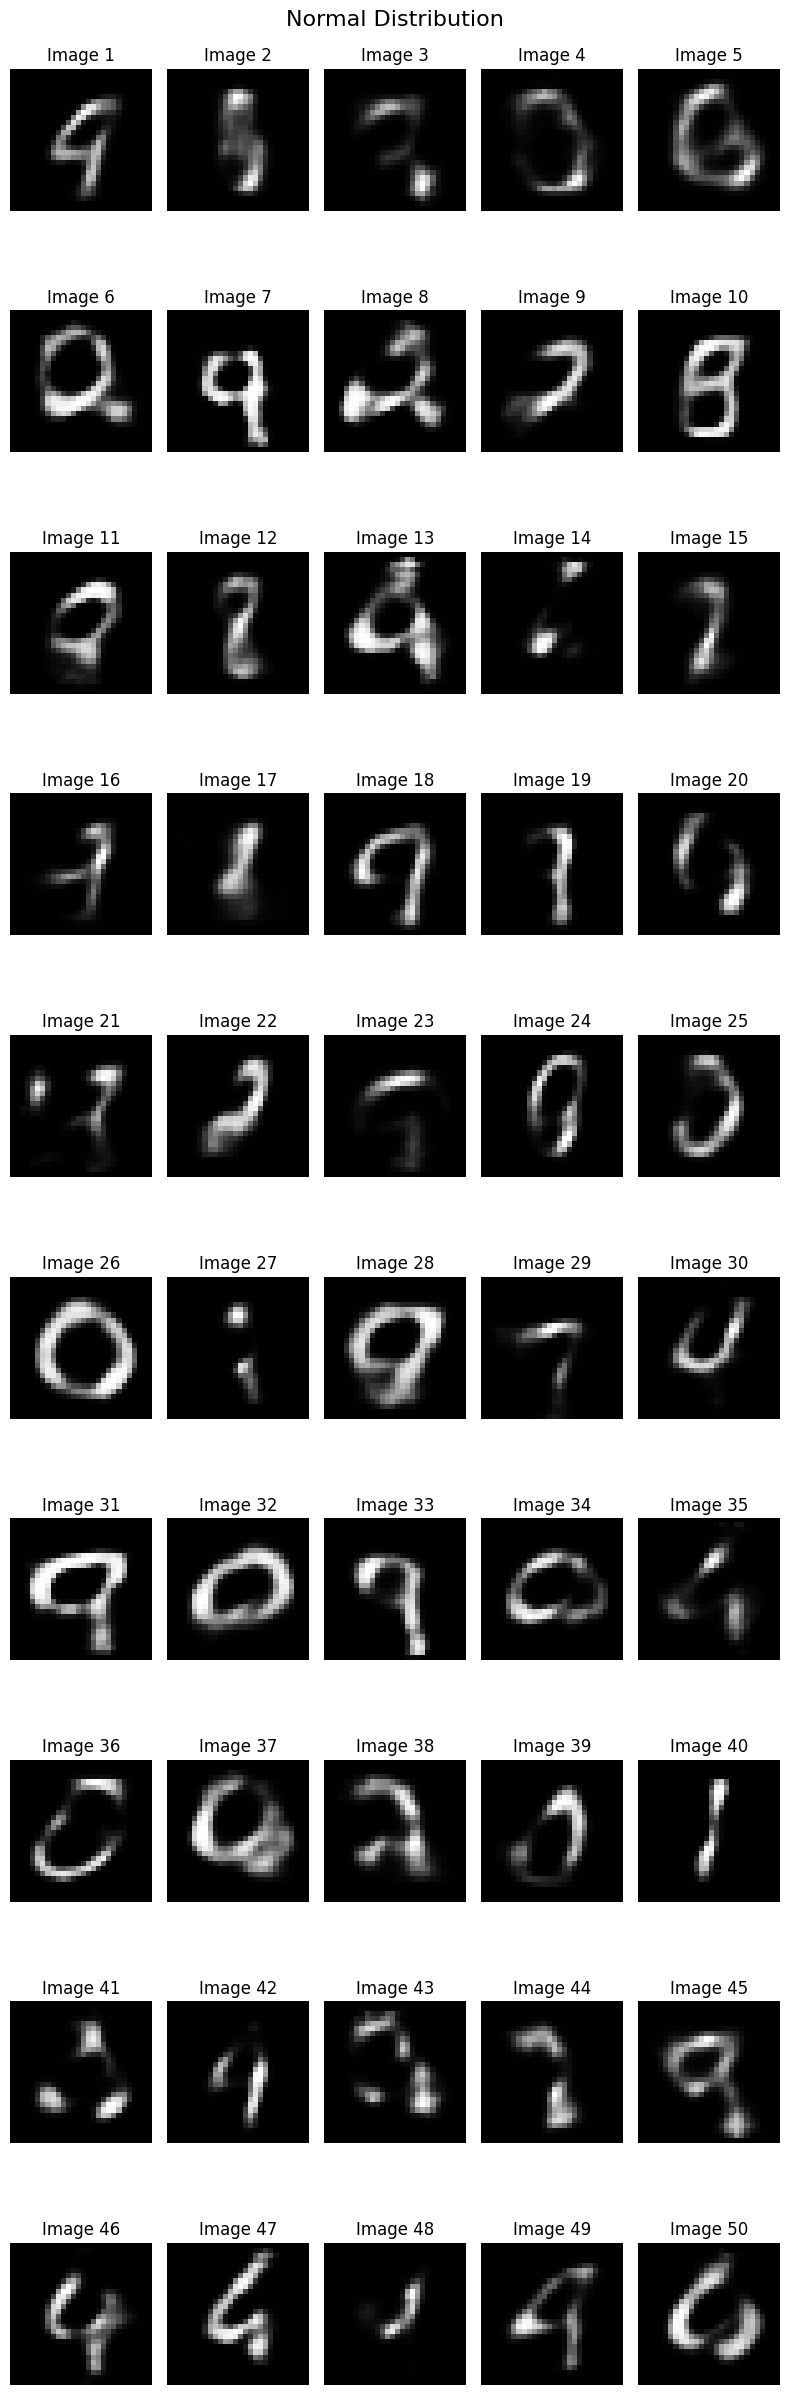

In [23]:
# Plot the generated digits
plt.figure(figsize=(8, 25))  # Adjust the figure size as needed

for i in range(num_images_gen):
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns (50 images in total)
    plt.imshow(digit_normal[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.suptitle('Normal Distribution', fontsize=16)  # Add the heading
plt.tight_layout()
plt.show()

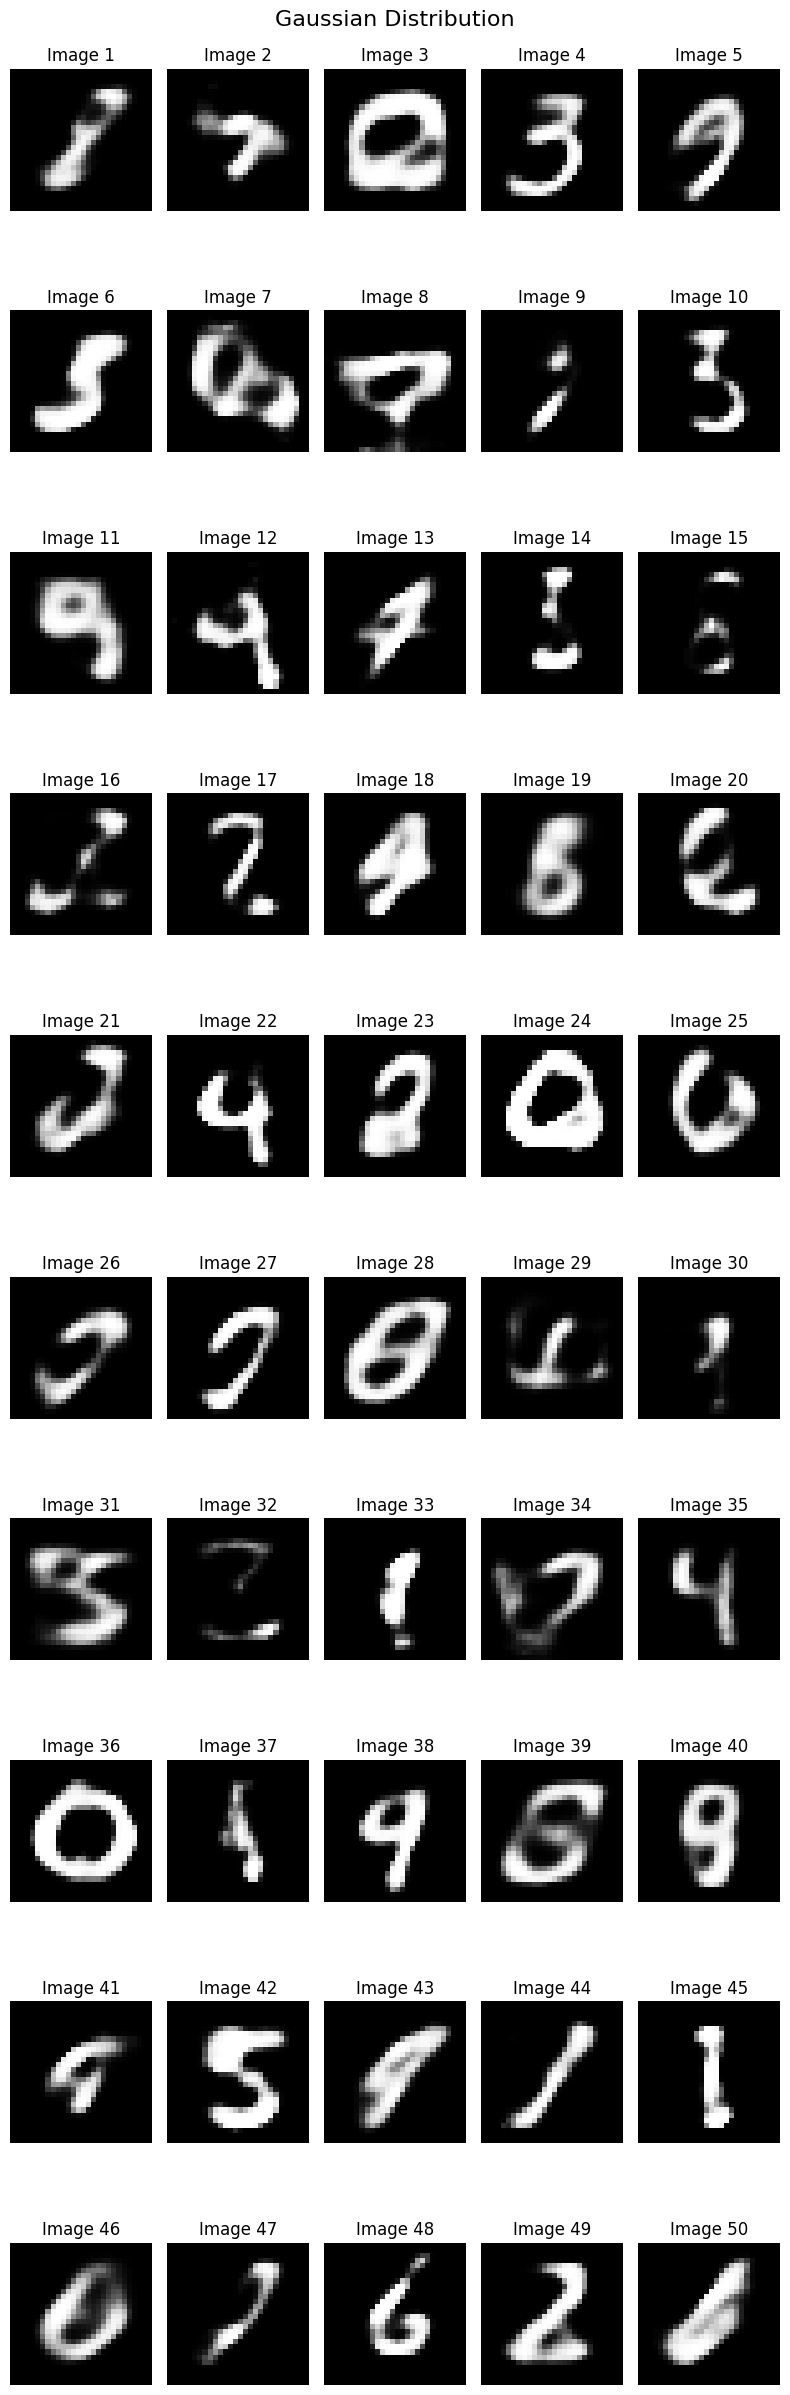

In [24]:
# Plot the generated digits
plt.figure(figsize=(8, 25))  # Adjust the figure size as needed

for i in range(num_images_gen):
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns (50 images in total)
    plt.imshow(digit_gaussian[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.suptitle('Gaussian Distribution', fontsize=16)  # Add the heading
plt.tight_layout()
plt.show()

1. The results from N(0,1) have become very bad because we have changed and reduced the weightage of KL Loss term.

2. The results from N(1,2) seem to improve but not by a very large margin.

3. Its possible to further better the results from N(1,2) by testing out different variations of the KL loss term and different weightages between KL loss and reproduction loss and by training for more epochs(I couldn't try it out due to time constraint).